# Interest Rate Prediction

## Case Study

This data belongs to a loan aggregator agency which connects loan applications to different financial institutions in attempt to get the best interest rate. They want to now utilise past data to predict interest rate given by any financial institute just by looking at loan application characteristics.

To achieve that , they have decided to do a POC with a data from a particular financial institution. The data is given in the file "loans data.csv". Lets begin: 

## Step 0: Basic Imports

In [43]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Load dataset

In [2]:
train_file='data/loan_data_train.csv' #relative path. So in present working directory it will look for data folder.
test_file='data/loan_data_test.csv'

df_train=pd.read_csv(train_file) #read_csv is a function in pandas.
df_test=pd.read_csv(test_file)               

In [3]:
print(df_train.shape) #check no of rows (ie the no of data points) and cols (ie the no of features)
df_train.head() #display the first 5 columns in your dataset

(2200, 15)


ID Amount.Requested Amount.Funded.By.Investors Interest.Rate  \
0  79542.0            25000                      25000        18.49%   
1  75473.0            19750                      19750        17.27%   
2  67265.0             2100                       2100        14.33%   
3  80167.0            28000                      28000        16.29%   
4  17240.0            24250                   17431.82        12.23%   

  Loan.Length        Loan.Purpose Debt.To.Income.Ratio State Home.Ownership  \
0   60 months  debt_consolidation               27.56%    VA       MORTGAGE   
1   60 months  debt_consolidation               13.39%    NY       MORTGAGE   
2   36 months      major_purchase                3.50%    LA            OWN   
3   36 months         credit_card               19.62%    NV       MORTGAGE   
4   60 months         credit_card               23.79%    OH       MORTGAGE   

   Monthly.Income FICO.Range Open.CREDIT.Lines Revolving.CREDIT.Balance  \
0         8606.56    720-724                11                    15210   
1         6737.50    710-714                14                    19070   
2         1000.00    690-694                13                      893   
3         7083.33    710-714                12                    38194   
4         5833.33    730-734                 6                    31061   

   Inquiries.in.the.Last.6.Months Employment.Length  
0                             3.0           5 years  
1                             3.0           4 years  
2                             1.0          < 1 year  
3                             1.0         10+ years  
4                             2.0         10+ years

14 features and 1 target variable

In [4]:
#test data does not have interest rate
print(df_test.shape)
df_test.head()

(300, 14)


ID  Amount.Requested Amount.Funded.By.Investors Loan.Length  \
0  20093              5000                       5000   60 months   
1  62445             18000                      18000   60 months   
2  65248              7200                       7200   60 months   
3  81822              7200                       7200   36 months   
4  57923             22000                      22000   60 months   

         Loan.Purpose Debt.To.Income.Ratio State Home.Ownership  \
0              moving               12.59%    NY           RENT   
1  debt_consolidation                4.93%    CA           RENT   
2  debt_consolidation               25.16%    LA       MORTGAGE   
3  debt_consolidation               17.27%    NY       MORTGAGE   
4  debt_consolidation               18.28%    MI       MORTGAGE   

   Monthly.Income FICO.Range Open.CREDIT.Lines  Revolving.CREDIT.Balance  \
0         4416.67    690-694                13                      7686   
1         5258.50    710-714                 6                     11596   
2         3750.00    750-754                13                      7283   
3         3416.67    790-794                14                      4838   
4         6083.33    720-724                 9                     20181   

   Inquiries.in.the.Last.6.Months Employment.Length  
0                               0          < 1 year  
1                               0         10+ years  
2                               0           6 years  
3                               0         10+ years  
4                               0           8 years

## Step 2: Data Visualisation and Feature Selection

### Check dtypes

In [5]:
#df_train.dtypes #this will return a list of the columns and their respective dtypes
df_train.dtypes.unique() #will give the unique dtypes in my dataset

array([dtype('float64'), dtype('O')], dtype=object)

In [6]:
#df_train.select_dtypes("object") --> this will return a dataframe with only object type columns
obj_cols = df_train.select_dtypes("object").columns
obj_cols, len(obj_cols)

(Index(['Amount.Requested', 'Amount.Funded.By.Investors', 'Interest.Rate',
        'Loan.Length', 'Loan.Purpose', 'Debt.To.Income.Ratio', 'State',
        'Home.Ownership', 'FICO.Range', 'Open.CREDIT.Lines',
        'Revolving.CREDIT.Balance', 'Employment.Length'],
       dtype='object'), 12)

Dtypes for 12 feature has to be fixed

In [7]:
df_train[obj_cols].sample(5) #slicing of dataframe-->dataframe[list_of_desired_cols]

Amount.Requested Amount.Funded.By.Investors Interest.Rate Loan.Length  \
1211             8400                       8400         6.92%   36 months   
1061            20000                      19900        18.17%   60 months   
1953             8000                       7950         7.90%   36 months   
378             15000                      15000        17.99%   36 months   
1351            15000                      15000         6.99%   36 months   

            Loan.Purpose Debt.To.Income.Ratio State Home.Ownership FICO.Range  \
1211    renewable_energy               13.30%    MD           RENT    745-749   
1061         credit_card                9.72%    CA       MORTGAGE    685-689   
1953    home_improvement               12.54%    IL       MORTGAGE    725-729   
378   debt_consolidation               21.04%    TX       MORTGAGE    675-679   
1351             medical                6.64%    MO       MORTGAGE    810-814   

     Open.CREDIT.Lines Revolving.CREDIT.Balance Employment.Length  
1211                 9                     6998            1 year  
1061                 8                   106527         10+ years  
1953                 8                     6834           5 years  
378                 13                     5613           2 years  
1351                12                     1410         10+ years

In [8]:
df_train["Loan.Length"].value_counts() #unique value and the count of each value

36 months    1722
60 months     476
.               1
Name: Loan.Length, dtype: int64

In [9]:
df_train["Loan.Purpose"].value_counts()

debt_consolidation    1147
credit_card            394
other                  174
home_improvement       135
major_purchase          84
small_business          80
car                     45
wedding                 35
medical                 26
moving                  25
house                   19
vacation                18
educational             14
renewable_energy         3
Name: Loan.Purpose, dtype: int64

### Some observations

1. 'Amount.Requested': **convert it to numeric**
2. 'Amount.Funded.By.Investors': **drop**
3. 'Interest.Rate': **remove % and then to numeric**
4. 'Loan.Length': **dummies for categories**
5. 'Loan.Purpose': **dummies for categories**
6. 'Debt.To.Income.Ratio': **remove % and then to numeric**
7. 'State': **dummies for categories**
8. 'Home.Ownership': **dummies for categories**
9. 'FICO.Range': **replace it by a numeric column which is average of the range**
10. 'Open.CREDIT.Lines': **convert it to numeric**
11. 'Revolving.CREDIT.Balance': **convert it to numeric**
12. 'Employment.Length': **convert it to number**


##### Lets group by operation:

1. drop: 
    - ID 
    - Amount.Funded.By.Investors
<br>
2. convert it to numeric 
    - Amount.Requested
    - Open.CREDIT.Lines
    - Revolving.CREDIT.Balance
<br>
3. remove % and then to numeric
    - Interest Rate
    - Debt to income ratio
<br>
4. replace it by a numeric column which is average of the range
    - FICO.Range 
<br>
5. convert to number:
    - Employment Length 
<br>
6. dummies for categories with good occurence rate:
    - Loan Lenth
    - Loan Purpose
    - State
    - Home ownership

### Fix Dtypes

#### Operation 1

In [10]:
df_train.drop(['ID','Amount.Funded.By.Investors'],axis=1,inplace=True)

#### Operation 2

We can see that many columns which should have really been numbers have been imported as character columns , probably because some characters values in those columns in the files. We'll convert all such columns to numbers .

In [11]:
for col in ['Amount.Requested', 'Open.CREDIT.Lines','Revolving.CREDIT.Balance']:
    df_train[col]=pd.to_numeric(df_train[col],errors='coerce') 

#### Operation 3

variable `Interest.Rate` and `Debt.To.Income.Ratio` contain "%" sign in their values and because of which they have come as character columns in the data. Lets remove these percentages first.

In [12]:
for col in ['Interest.Rate','Debt.To.Income.Ratio']:
    print(col)
    df_train[col]=df_train[col].str.replace("%","") #first convert the row value to string type
                                                    #and then perfrom replace operation

Interest.Rate
Debt.To.Income.Ratio


In [13]:
#Lets check the effect of replace operation
df_train["Interest.Rate"].head()

0    18.49
1    17.27
2    14.33
3    16.29
4    12.23
Name: Interest.Rate, dtype: object

In [14]:
#Now we can convert to numeric
for col in ['Interest.Rate','Debt.To.Income.Ratio']:
    df_train[col]=pd.to_numeric(df_train[col],errors='coerce') 

#### Operation 4

If we look at first few values of variable FICO.Range , we can see that we can convert it to numeric by taking average of the range given. To do that first we need to split the column with "-", so that we can have both end of ranges in separate columns and then we can simply average them.

In [15]:
#"660-770".split("-") #for understanding

In [16]:
k=df_train['FICO.Range'].str.split("-",expand=True).astype(float)

In [17]:
#now k is a new dataframe with two columns and same no of rows
k.head()

0      1
0  720.0  724.0
1  710.0  714.0
2  690.0  694.0
3  710.0  714.0
4  730.0  734.0

In [18]:
#creating a new column "fico" with average from k[0] (ie lower range) and k[1] (ie upper range)
df_train['fico']=0.5*(k[0]+k[1])
del df_train['FICO.Range']

#### Operation 5

In [19]:
#checking unique values for "Employment.Length" and their corresponding values
df_train['Employment.Length'].value_counts()

10+ years    575
< 1 year     229
2 years      217
3 years      203
5 years      181
4 years      162
1 year       159
6 years      134
7 years      109
8 years       95
9 years       66
.              1
Name: Employment.Length, dtype: int64

In [20]:
df_train['Employment.Length']=df_train['Employment.Length'].str.replace('years',"")
df_train['Employment.Length']=df_train['Employment.Length'].str.replace('year',"")

In [21]:
#verifying the two replace operations we performed
df_train['Employment.Length'].head()

0      5 
1      4 
2    < 1 
3    10+ 
4    10+ 
Name: Employment.Length, dtype: object

In [22]:
#"10+"[:2] #take index 0 and index 1. 

In [23]:
#np.where(condition, value_if_True, value_if_False)
df_train['Employment.Length']=np.where(df_train['Employment.Length'].str[:2]=="10",10,
                                       df_train['Employment.Length'])

df_train['Employment.Length']=np.where(df_train['Employment.Length'].str[0]=="<",0,
                                       df_train['Employment.Length'])

In [24]:
df_train['Employment.Length'].head()

0    5 
1    4 
2     0
3    10
4    10
Name: Employment.Length, dtype: object

In [25]:
df_train['Employment.Length']=pd.to_numeric(df_train['Employment.Length'],errors='coerce')

In [26]:
df_train['Employment.Length'].head()

0     5.0
1     4.0
2     0.0
3    10.0
4    10.0
Name: Employment.Length, dtype: float64

#### Operation 6

In [27]:
# Notice that to apply string function on pandas data frame columns you need to str attribute
cat_cols=df_train.select_dtypes(['object']).columns
cat_cols

Index(['Loan.Length', 'Loan.Purpose', 'State', 'Home.Ownership'], dtype='object')

In [28]:
print("*"*50)
for col in cat_cols:
    print(col)
    print("-"*50)
    print(df_train[col].nunique())
    print(df_train[col].value_counts())
    print("*"*50)

**************************************************
Loan.Length
--------------------------------------------------
3
36 months    1722
60 months     476
.               1
Name: Loan.Length, dtype: int64
**************************************************
Loan.Purpose
--------------------------------------------------
14
debt_consolidation    1147
credit_card            394
other                  174
home_improvement       135
major_purchase          84
small_business          80
car                     45
wedding                 35
medical                 26
moving                  25
house                   19
vacation                18
educational             14
renewable_energy         3
Name: Loan.Purpose, dtype: int64
**************************************************
State
--------------------------------------------------
46
CA    376
NY    231
FL    149
TX    146
PA     88
IL     87
GA     82
NJ     81
VA     70
MA     64
OH     59
MD     59
NC     59
CO     54
WA     52
CT     4

In [29]:
# you can use following method if you want to ignore categories with too low frequencies ,
# in next section for logistic regression we will be using  pandas' get dummies function. 
# you can work with either of these . 
# ignoring categories with low frequencies however will result in fewer columns without 
# affecting model performance too much .
to_store = []
new_cols = []
for col in cat_cols:
    freqs=df_train[col].value_counts()
    categories = freqs.index[freqs>20][:-1]
    to_store.append((col, categories))
    for category in categories:
        name=col+'.'+category
        new_cols.append(name)
        df_train[name]=(df_train[col]==category).astype(int)
    del df_train[col]
    print(col)

Loan.Length
Loan.Purpose
State
Home.Ownership


In [34]:
new_cols

['Loan.Length.36 months',
 'Loan.Purpose.debt_consolidation',
 'Loan.Purpose.credit_card',
 'Loan.Purpose.other',
 'Loan.Purpose.home_improvement',
 'Loan.Purpose.major_purchase',
 'Loan.Purpose.small_business',
 'Loan.Purpose.car',
 'Loan.Purpose.wedding',
 'Loan.Purpose.medical',
 'State.CA',
 'State.NY',
 'State.FL',
 'State.TX',
 'State.PA',
 'State.IL',
 'State.GA',
 'State.NJ',
 'State.VA',
 'State.MA',
 'State.OH',
 'State.MD',
 'State.NC',
 'State.CO',
 'State.WA',
 'State.CT',
 'State.AZ',
 'State.MI',
 'State.AL',
 'State.MN',
 'State.NV',
 'State.MO',
 'State.SC',
 'State.OR',
 'State.WI',
 'Home.Ownership.MORTGAGE',
 'Home.Ownership.RENT']

In [32]:
df_train.dtypes.unique() #mission successful

array([dtype('float64'), dtype('int64')], dtype=object)

### Correlation Coefficient

In [37]:
numerical = df_train[df_train.columns.drop(new_cols)]

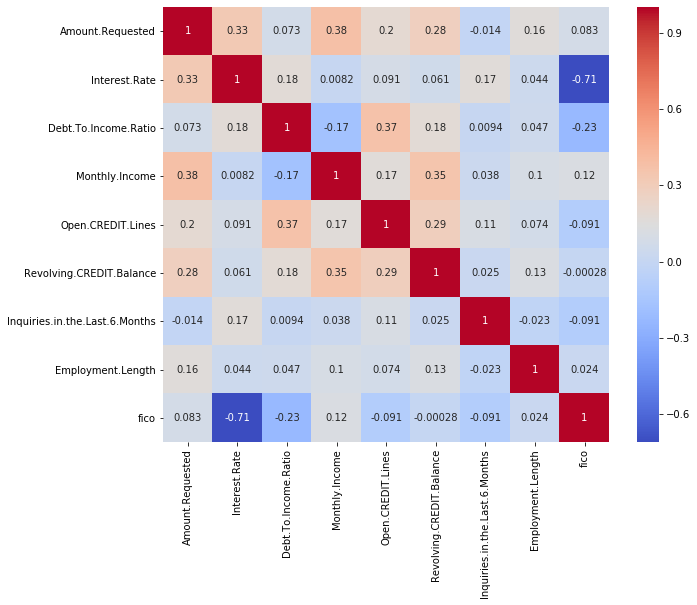

In [44]:
ax, fig = plt.subplots(figsize=(10,8))
sns.heatmap(numerical.corr(), annot=True, cmap='coolwarm')
plt.show()

### Outliers

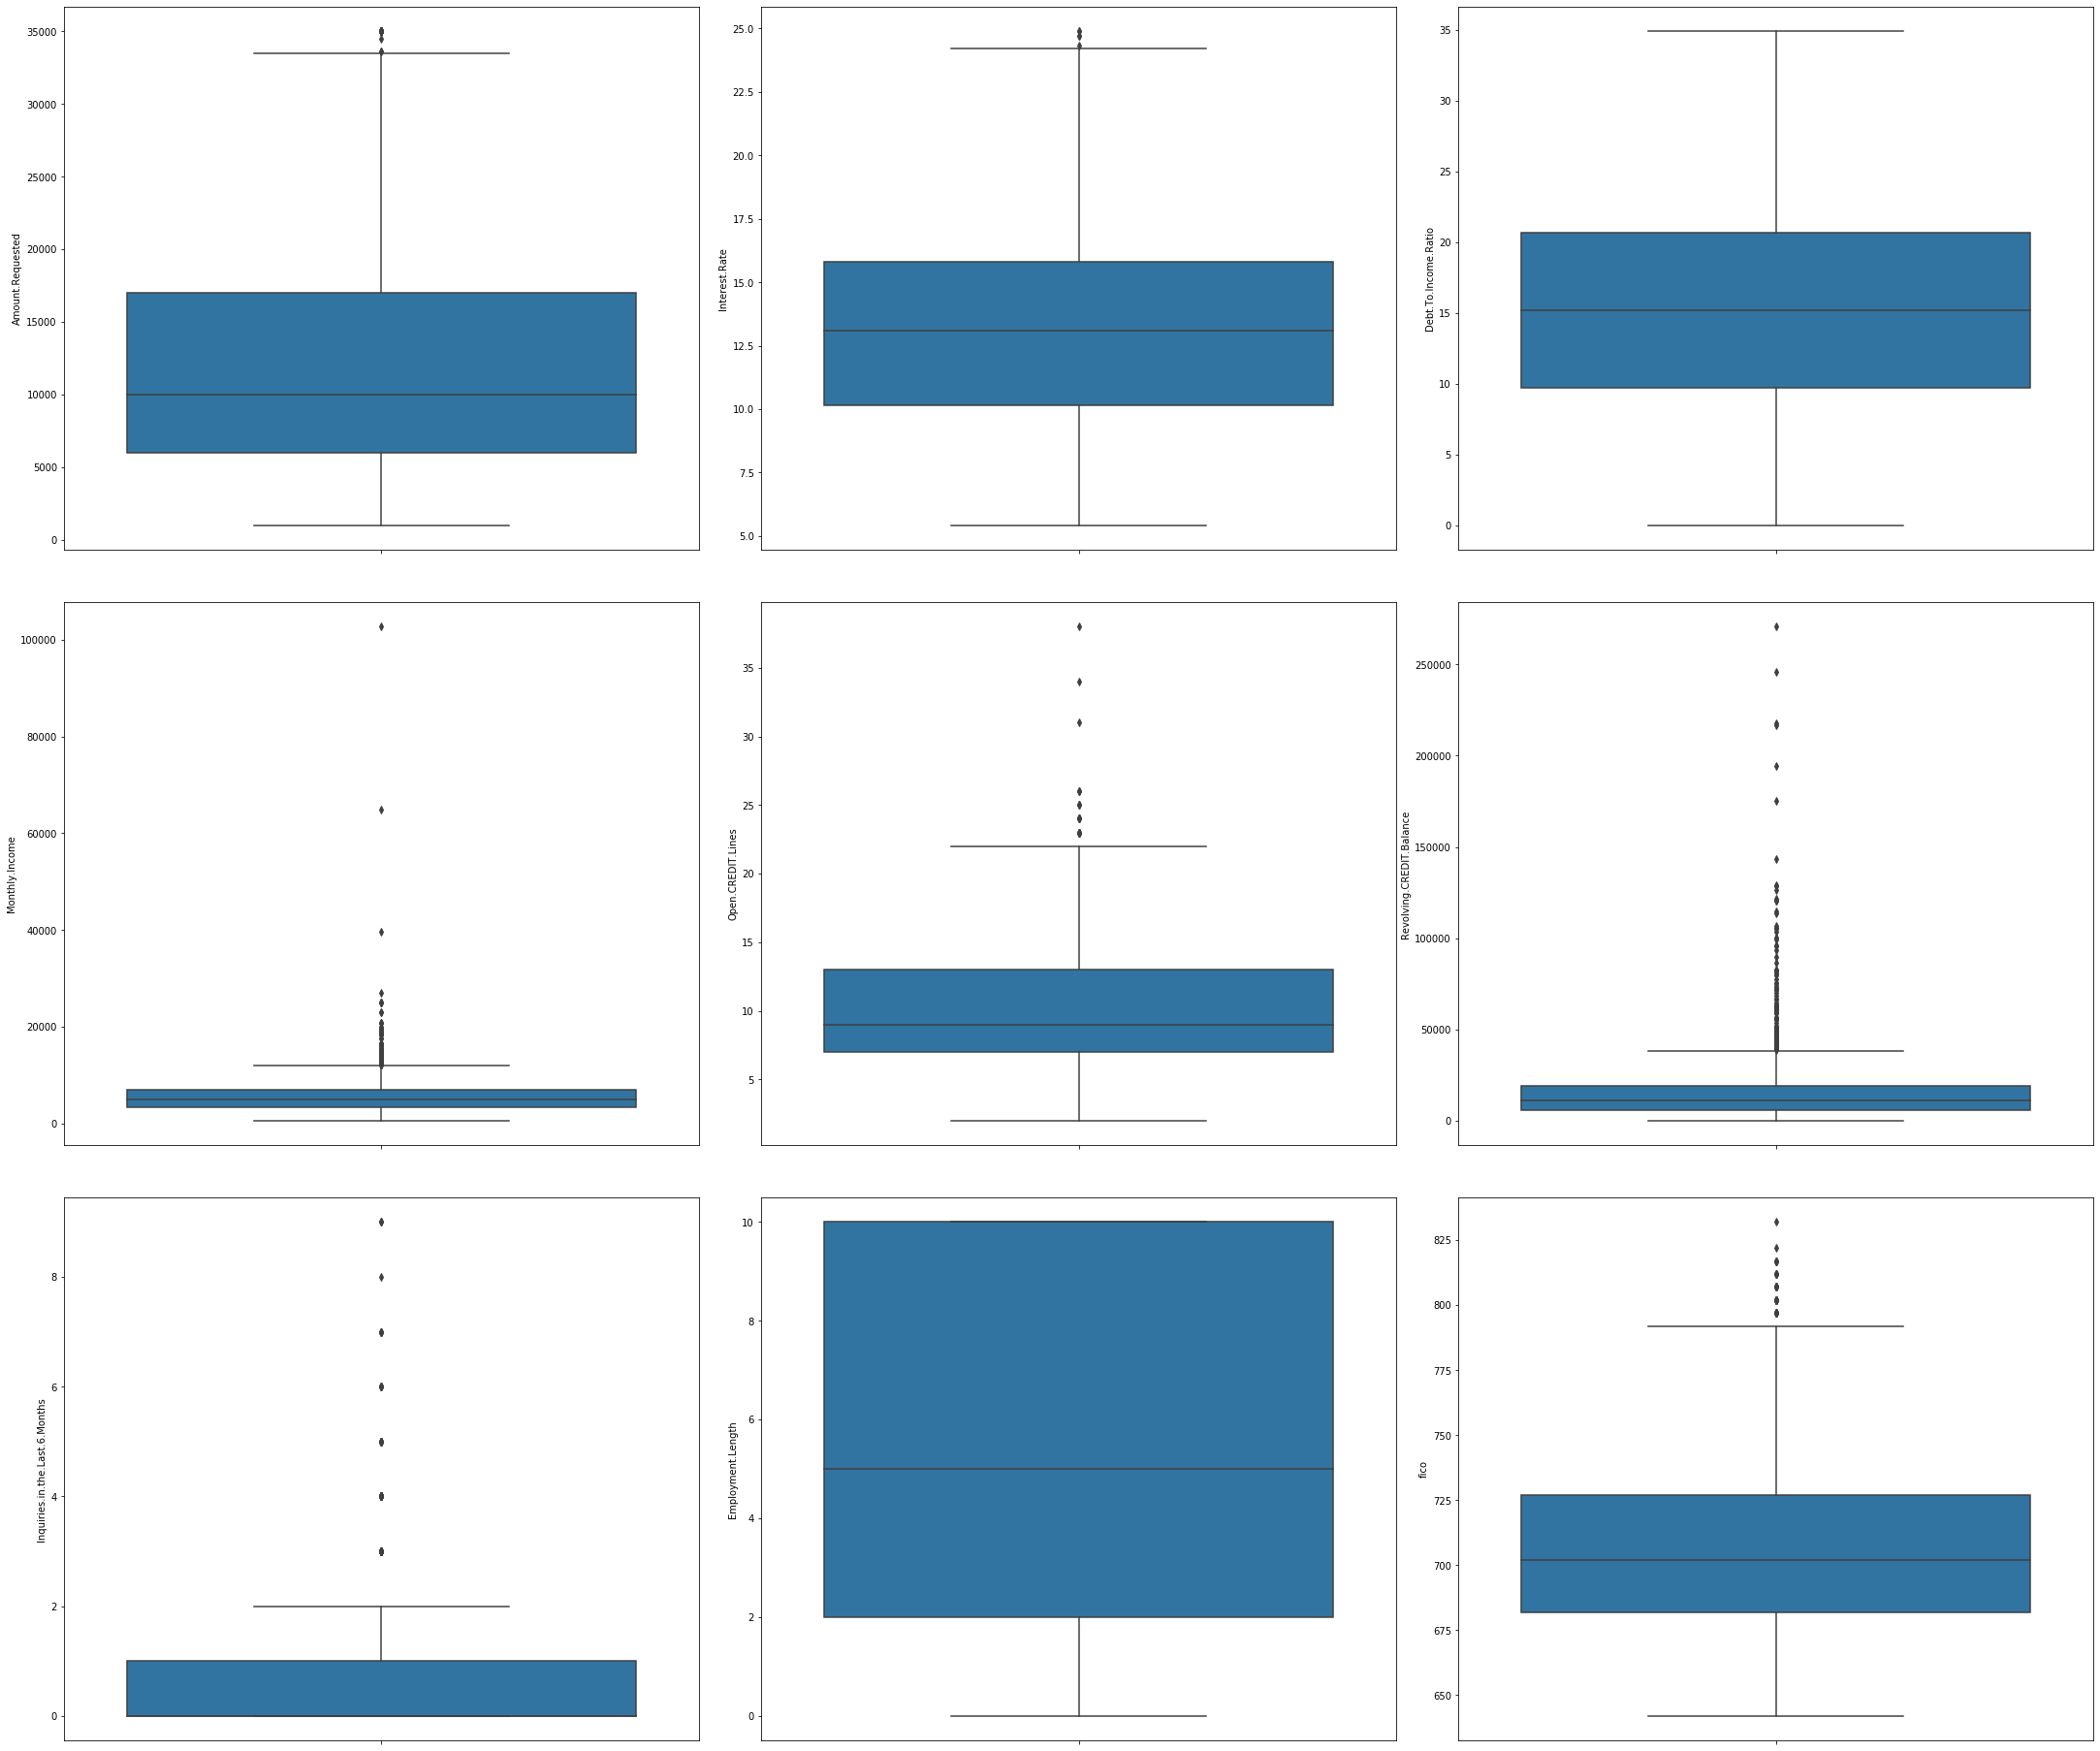

In [51]:
from scipy import stats

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(30, 25))
index = 0
axs = axs.flatten()
for k,v in numerical.items():
    sns.boxplot(y=k, data=numerical, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [53]:
for k, v in numerical.items(): #k=column_name, v=values
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(numerical)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column Amount.Requested outliers = 2.32%
Column Interest.Rate outliers = 0.23%
Column Debt.To.Income.Ratio outliers = 0.00%
Column Monthly.Income outliers = 4.95%
Column Open.CREDIT.Lines outliers = 1.55%
Column Revolving.CREDIT.Balance outliers = 5.64%
Column Inquiries.in.the.Last.6.Months outliers = 10.09%
Column Employment.Length outliers = 0.00%
Column fico outliers = 2.23%


### Missing values

In [54]:
df_train.isnull().sum()

Amount.Requested                    5
Interest.Rate                       0
Debt.To.Income.Ratio                1
Monthly.Income                      3
Open.CREDIT.Lines                   7
Revolving.CREDIT.Balance            5
Inquiries.in.the.Last.6.Months      3
Employment.Length                  70
fico                                0
Loan.Length.36 months               0
Loan.Purpose.debt_consolidation     0
Loan.Purpose.credit_card            0
Loan.Purpose.other                  0
Loan.Purpose.home_improvement       0
Loan.Purpose.major_purchase         0
Loan.Purpose.small_business         0
Loan.Purpose.car                    0
Loan.Purpose.wedding                0
Loan.Purpose.medical                0
State.CA                            0
State.NY                            0
State.FL                            0
State.TX                            0
State.PA                            0
State.IL                            0
State.GA                            0
State.NJ    

In [55]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [56]:
df_train = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)

In [57]:
df_train.isnull().sum()

Amount.Requested                   0
Interest.Rate                      0
Debt.To.Income.Ratio               0
Monthly.Income                     0
Open.CREDIT.Lines                  0
Revolving.CREDIT.Balance           0
Inquiries.in.the.Last.6.Months     0
Employment.Length                  0
fico                               0
Loan.Length.36 months              0
Loan.Purpose.debt_consolidation    0
Loan.Purpose.credit_card           0
Loan.Purpose.other                 0
Loan.Purpose.home_improvement      0
Loan.Purpose.major_purchase        0
Loan.Purpose.small_business        0
Loan.Purpose.car                   0
Loan.Purpose.wedding               0
Loan.Purpose.medical               0
State.CA                           0
State.NY                           0
State.FL                           0
State.TX                           0
State.PA                           0
State.IL                           0
State.GA                           0
State.NJ                           0
S

## Step 3: Defining Training and Test Set

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X_train, y_train = df_train.loc[:,df_train.columns!="Interest.Rate"].values, df_train["Interest.Rate"].values
X_train.shape, y_train.shape

((2200, 45), (2200,))

## Step 4: Data Scaling

In [60]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler().fit(X_train)
X_train = std.transform(X_train)

## Step 5: Test set pipeline

In [61]:
def preprocessing(dataframe, to_store):
    
    #Operation1
    dataframe = dataframe.drop(['ID','Amount.Funded.By.Investors'],axis=1)
    
    #Operation2
    for col in ['Amount.Requested', 'Open.CREDIT.Lines','Revolving.CREDIT.Balance']:
        dataframe[col]=pd.to_numeric(dataframe[col],errors='coerce')
    
    #Operation3
    for col in ['Debt.To.Income.Ratio']:
        dataframe[col] = dataframe[col].str.replace("%","") 
    
    for col in ['Debt.To.Income.Ratio']:
        dataframe[col]=pd.to_numeric(dataframe[col],errors='coerce') 
    
    #Operation4
    k=dataframe['FICO.Range'].str.split("-",expand=True).astype(float)
    dataframe['fico']=0.5*(k[0]+k[1])
    del dataframe['FICO.Range']
    
    #Operation5
    dataframe['Employment.Length']=dataframe['Employment.Length'].str.replace('years',"")
    dataframe['Employment.Length']=dataframe['Employment.Length'].str.replace('year',"")
    
    dataframe['Employment.Length']=np.where(dataframe['Employment.Length'].str[:2]=="10",10,
                                       dataframe['Employment.Length'])

    dataframe['Employment.Length']=np.where(dataframe['Employment.Length'].str[0]=="<",0,
                                       dataframe['Employment.Length'])
    
    dataframe['Employment.Length']=pd.to_numeric(dataframe['Employment.Length'],errors='coerce')
    
    #Operation6
    for column, categories in to_store:
        for category in categories:
            name=column+'.'+category
            dataframe[name]=(dataframe[column]==category).astype(int)
        del dataframe[column]
    
    #Missing values
    dataframe = pd.DataFrame(imputer.fit_transform(dataframe), columns=dataframe.columns)
    
    X_test = dataframe.values
    X_test = std.transform(X_test)
    
    return X_test

In [62]:
X_test = preprocessing(df_test, to_store)
X_test.shape

(300, 45)

## Step 6: Modelling

### Linear Regression

In [63]:
from sklearn.linear_model import LinearRegression

lm=LinearRegression()

lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
test_pred = lm.predict(X_test)

We can write these to a csv file for submission like this :

In [65]:
pd.DataFrame(test_pred).to_csv("mysubmission.csv",index=False)

### Ridge  Regression

In [66]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [67]:
model=Ridge()

In [68]:
lambdas=np.linspace(1,100,100) #defiing range for values for lambda
params={'alpha':lambdas}

In [69]:
grid_search = GridSearchCV(model, param_grid=params, cv=10, scoring='neg_mean_absolute_error')

In [70]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,...
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.]

In [71]:
grid_search.best_estimator_

Ridge(alpha=5.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [72]:
grid_search.cv_results_

{'mean_fit_time': array([0.00212629, 0.00160275, 0.0015451 , 0.00135899, 0.00122128,
        0.00126696, 0.00122786, 0.00117986, 0.00117753, 0.00114768,
        0.00121078, 0.00147374, 0.00161231, 0.00149913, 0.00117905,
        0.00118449, 0.0011107 , 0.00114703, 0.0012249 , 0.00112267,
        0.00159271, 0.00141377, 0.00135584, 0.00121434, 0.00112114,
        0.00114012, 0.00118916, 0.00116863, 0.00120885, 0.00117764,
        0.00123281, 0.00115504, 0.00113165, 0.00110481, 0.00114048,
        0.00116193, 0.0011188 , 0.0015209 , 0.00140307, 0.0012198 ,
        0.00113032, 0.0011435 , 0.00112035, 0.00112686, 0.0011687 ,
        0.00121014, 0.00122576, 0.00137777, 0.0011369 , 0.00120406,
        0.0011106 , 0.00112026, 0.00117137, 0.00112491, 0.00149541,
        0.00161061, 0.0017468 , 0.00131714, 0.00115891, 0.00115793,
        0.00121169, 0.00114374, 0.00118697, 0.00119276, 0.00118601,
        0.00112202, 0.00114708, 0.00142863, 0.00170927, 0.00131233,
        0.00132267, 0.00131209,

 if you want you can now fit a ridge regression model with obtained value of alpha , although there is no need, grid search automatically fits the best estimator on the entire data, you can directly use this to make predictions on test_data. But if you want to look at coefficients , its much more convenient to fit the model with direct function

Using the report function given below you can see the cv performance of top few models as well, that will the tentative performance

In [73]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [74]:
report(grid_search.cv_results_,100)

Model with rank: 1
Mean validation score: -1.615 (std: 0.115)
Parameters: {'alpha': 5.0}

Model with rank: 2
Mean validation score: -1.615 (std: 0.115)
Parameters: {'alpha': 6.0}

Model with rank: 3
Mean validation score: -1.615 (std: 0.115)
Parameters: {'alpha': 4.0}

Model with rank: 4
Mean validation score: -1.615 (std: 0.115)
Parameters: {'alpha': 3.0}

Model with rank: 5
Mean validation score: -1.615 (std: 0.115)
Parameters: {'alpha': 7.0}

Model with rank: 6
Mean validation score: -1.615 (std: 0.115)
Parameters: {'alpha': 2.0}

Model with rank: 7
Mean validation score: -1.615 (std: 0.115)
Parameters: {'alpha': 1.0}

Model with rank: 8
Mean validation score: -1.615 (std: 0.115)
Parameters: {'alpha': 8.0}

Model with rank: 9
Mean validation score: -1.615 (std: 0.115)
Parameters: {'alpha': 9.0}

Model with rank: 10
Mean validation score: -1.615 (std: 0.115)
Parameters: {'alpha': 10.0}

Model with rank: 11
Mean validation score: -1.615 (std: 0.115)
Parameters: {'alpha': 11.0}

Model 

In [75]:
test_pred=grid_search.predict(X_test)

In [76]:
pd.DataFrame(test_pred).to_csv("mysubmission.csv",index=False)